In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

In [3]:
import sys
sys.path += ["../../../MLPF/mlpf/particleflow/mlpf/"]
from tfmodel.model_setup import make_model
from tfmodel.utils import parse_config

import tensorflow as tf
import tensorflow_datasets as tfds

import pathlib

2024-02-02 21:08:41.418688: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
ds_builder = tfds.builder("clic_edm_qq_pf", data_dir = '../../../MLPF/mlpf/tensorflow_datasets/') # Tensorflow datsets positions in the lxplus
dss = ds_builder.as_data_source("test")

In [5]:
def yield_from_ds():
    for elem in dss:
        yield {"X": elem["X"], "ygen": elem["ygen"], "ycand": elem["ycand"]}

In [6]:
output_signature = {k: tf.TensorSpec(shape=(None, v.shape[1])) for (k, v) in dss.dataset_info.features.items()}
tf_dataset = tf.data.Dataset.from_generator(yield_from_ds, output_signature=output_signature).take(100).padded_batch(batch_size=10)

In [7]:
output_signature

{'X': TensorSpec(shape=(None, 17), dtype=tf.float32, name=None),
 'ycand': TensorSpec(shape=(None, 8), dtype=tf.float32, name=None),
 'ygen': TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)}

In [8]:
data = list(tfds.as_numpy(tf_dataset))

In [9]:
Xs = [d["X"] for d in data]
ys = [d["ygen"] for d in data]

In [10]:
ys[0][9][:,:4]

array([[ 1.        , -1.        ,  3.5555263 ,  0.22640967],
       [ 1.        , -1.        ,  2.4462407 ,  0.195159  ],
       [ 1.        ,  1.        ,  0.8356094 , -0.5446882 ],
       [ 1.        ,  1.        ,  0.85157084, -1.37132   ],
       [ 1.        ,  1.        ,  0.6311886 , -0.9460032 ],
       [ 1.        ,  1.        ,  0.560444  , -0.38950145],
       [ 1.        , -1.        ,  0.50040615, -0.29128084],
       [ 1.        , -1.        ,  0.40326795,  0.19255948],
       [ 1.        ,  1.        ,  0.37885737,  0.12188682],
       [ 1.        , -1.        ,  0.36663368, -2.1641972 ],
       [ 1.        ,  1.        ,  0.3846691 ,  0.68863004],
       [ 1.        ,  1.        ,  0.3615032 , -0.81029856],
       [ 1.        , -1.        ,  0.18166022,  0.15179   ],
       [ 1.        , -1.        ,  0.21182844,  1.8761586 ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 1.        , -1.        ,  0.16170818, -0.88895464],
       [ 1.        ,  1.

In [11]:
#batch 0, max 111 particles per event
Xs[0].shape

(10, 111, 17)

In [12]:
#batch 3 has 10 events, max 90 particles per event
Xs[3].shape

(10, 90, 17)

In [13]:
# Check the lengths of sublists in Xs
sublist_lengths = [len(sublist) for sublist in Xs]
print("Lengths of sublists in Xs:", sublist_lengths)


Lengths of sublists in Xs: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


In [14]:
for X_q in Xs:
    print("Shape of X_q:", X_q.shape) 

Shape of X_q: (10, 111, 17)
Shape of X_q: (10, 186, 17)
Shape of X_q: (10, 142, 17)
Shape of X_q: (10, 90, 17)
Shape of X_q: (10, 111, 17)
Shape of X_q: (10, 195, 17)
Shape of X_q: (10, 100, 17)
Shape of X_q: (10, 81, 17)
Shape of X_q: (10, 130, 17)
Shape of X_q: (10, 147, 17)


In [15]:
for y_q in ys:
    print("Shape of yq:", y_q.shape)

Shape of yq: (10, 111, 8)
Shape of yq: (10, 186, 8)
Shape of yq: (10, 142, 8)
Shape of yq: (10, 90, 8)
Shape of yq: (10, 111, 8)
Shape of yq: (10, 195, 8)
Shape of yq: (10, 100, 8)
Shape of yq: (10, 81, 8)
Shape of yq: (10, 130, 8)
Shape of yq: (10, 147, 8)


## Quantizing the model
### post-training dynamic range quantization

Quantizing with post-training dynamic range quantization.
Using the TensorFlow Lite Converter, you can now convert the trained model into a TensorFlow Lite model.



In [16]:
config, _ = parse_config("../../../MLPF/mlpf/particleflow/parameters/clic.yaml") #positions on the lxplus
config["setup"]["multi_output"] = False
model = make_model(config, tf.float32)
Xdummy = np.zeros((10,256,17), dtype=np.float32)
model(Xdummy)
model.load_weights("weights-96-5.346523.hdf5", skip_mismatch=False, by_name=True)

In [17]:
model.summary()

Model: "pf_net_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 node_encoding (Sequential)  (10, 256, 256)            70912     
                                                                 
 input_encoding_clic (Input  multiple                  0         
 EncodingCLIC)                                                   
                                                                 
 cg_id_0 (CombinedGraphLaye  multiple                  440128    
 r)                                                              
                                                                 
 cg_id_1 (CombinedGraphLaye  multiple                  440128    
 r)                                                              
                                                                 
 cg_id_2 (CombinedGraphLaye  multiple                  440128    
 r)                                                   

In [18]:
true_pts = []
pred_pts = []
#loop over batches
for i in range(len(Xs)):
    this_X = Xs[i]
    print(this_X.shape)
    pad_size = [[0,0],[0,Xdummy.shape[1]-this_X.shape[1]], [0,0]]
    this_X = tf.pad(this_X, pad_size)
    this_ys = tf.pad(ys[i], pad_size)

    ret = model(this_X)
    msk_true_part = this_ys[..., 0]!=0
    true_pts.append(this_ys[msk_true_part][..., 2])
    pred_pts.append(ret[msk_true_part][..., 9])
true_pts = np.hstack(true_pts)
pred_pts = np.hstack(pred_pts)

(10, 111, 17)
(10, 186, 17)
(10, 142, 17)
(10, 90, 17)
(10, 111, 17)
(10, 195, 17)
(10, 100, 17)
(10, 81, 17)
(10, 130, 17)
(10, 147, 17)


Text(0, 0.5, 'predicted pt')

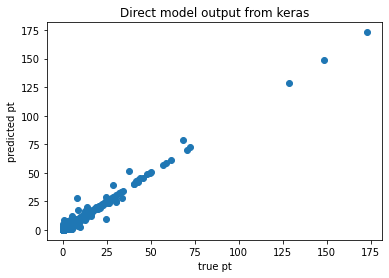

In [19]:
plt.title("Direct model output from keras")
plt.scatter(true_pts, pred_pts)
plt.xlabel("true pt")
plt.ylabel("predicted pt")

In [20]:
def representative_dataset():
    for i in range(len(Xs)):
        this_X = Xs[i]
        pad_size = [[0,0],[0,Xdummy.shape[1]-this_X.shape[1]], [0,0]]
        this_X = tf.pad(this_X, pad_size)
        #yield [tf.clip_by_value(this_X, -1000, 1000)]
        yield [this_X]
        #yield [Xs[i]]


In [21]:
for elem in representative_dataset():
    print(tf.reduce_max(elem[0]), tf.reduce_min(elem[0]))

tf.Tensor(3919.2617, shape=(), dtype=float32) tf.Tensor(-3914.5479, shape=(), dtype=float32)
tf.Tensor(4024.4985, shape=(), dtype=float32) tf.Tensor(-3708.8445, shape=(), dtype=float32)
tf.Tensor(3458.0308, shape=(), dtype=float32) tf.Tensor(-4052.0835, shape=(), dtype=float32)
tf.Tensor(107094.65, shape=(), dtype=float32) tf.Tensor(-3970.2178, shape=(), dtype=float32)
tf.Tensor(4110.499, shape=(), dtype=float32) tf.Tensor(-3964.783, shape=(), dtype=float32)
tf.Tensor(3637.2292, shape=(), dtype=float32) tf.Tensor(-3177.4062, shape=(), dtype=float32)
tf.Tensor(4067.0532, shape=(), dtype=float32) tf.Tensor(-3857.043, shape=(), dtype=float32)
tf.Tensor(3032.948, shape=(), dtype=float32) tf.Tensor(-3638.6091, shape=(), dtype=float32)
tf.Tensor(3653.201, shape=(), dtype=float32) tf.Tensor(-3358.871, shape=(), dtype=float32)
tf.Tensor(3678.1904, shape=(), dtype=float32) tf.Tensor(-3952.1936, shape=(), dtype=float32)


In [22]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.representative_dataset = representative_dataset
#converter.experimental_enable_quantizer = True
tflite_model = converter.convert()

/cvmfs/sft.cern.ch/lcg/views/LCG_105/x86_64-el9-gcc13-opt/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2024-02-02 21:14:18.912798: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2024-02-02 21:14:18.913024: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2024-02-02 21:14:18.913939: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/sraj/tmp77cwh1zz
2024-02-02 21:14:18.991490: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2024-02-02 21:14:18.991551: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/sraj/tmp77cwh1zz
2024-02-02 21:14:19.220921: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2

Convert with debug options, check which tensors have a large discrepancy.

In [23]:
debug_options = tf.lite.experimental.QuantizationDebugOptions()

debugger = tf.lite.experimental.QuantizationDebugger(
    converter=converter, debug_dataset=representative_dataset, debug_options=debug_options)

debugger.run()

RESULTS_FILE = 'debugger_results.csv'
with open(RESULTS_FILE, 'w') as f:
  debugger.layer_statistics_dump(f)

/cvmfs/sft.cern.ch/lcg/views/LCG_105/x86_64-el9-gcc13-opt/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2024-02-02 21:20:30.637781: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2024-02-02 21:20:30.637848: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2024-02-02 21:20:30.638330: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/sraj/tmpwl9z4vbb
2024-02-02 21:20:30.719313: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2024-02-02 21:20:30.719372: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/sraj/tmpwl9z4vbb
2024-02-02 21:20:30.983839: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2024-02-02 21:20:31.905234: I tens

In [24]:
import pandas

In [25]:
debug_data = pandas.read_csv("debugger_results.csv")

In [26]:
bad_tensors = list(debug_data[debug_data["mean_squared_error"]>1e5].tensor_name.values)

In [27]:
bad_tensors

['pf_net_dense/input_encoding_clic/one_hot',
 'pf_net_dense/node_encoding/node_encoding_dense_0/Tensordot/MatMul2',
 'pf_net_dense/node_encoding/node_encoding_dense_1/Tensordot/MatMul1',
 'pf_net_dense/cg_id_0/cg_id_0_layernorm1/moments/mean',
 'pf_net_dense/cg_id_0/cg_id_0_layernorm1/moments/SquaredDifference',
 'pf_net_dense/cg_id_0/cg_id_0_layernorm1/moments/variance',
 'pf_net_dense/cg_id_1/cg_id_1_layernorm1/moments/mean',
 'pf_net_dense/cg_id_1/cg_id_1_layernorm1/moments/SquaredDifference',
 'pf_net_dense/cg_id_1/cg_id_1_layernorm1/moments/variance',
 'pf_net_dense/cg_id_2/cg_id_2_layernorm1/moments/mean',
 'pf_net_dense/cg_id_2/cg_id_2_layernorm1/moments/SquaredDifference',
 'pf_net_dense/cg_id_2/cg_id_2_layernorm1/moments/variance',
 'pf_net_dense/cg_id_3/cg_id_3_layernorm1/moments/mean',
 'pf_net_dense/cg_id_3/cg_id_3_layernorm1/moments/SquaredDifference',
 'pf_net_dense/cg_id_3/cg_id_3_layernorm1/moments/variance',
 'pf_net_dense/cg_id_4/cg_id_4_layernorm1/moments/mean',
 'pf

Now convert again, excluding tensors that have a large discrepancy.

In [28]:
debug_options = tf.lite.experimental.QuantizationDebugOptions(
    denylisted_nodes=bad_tensors
    #denylisted_ops=["ONE_HOT", "SQUARED_DIFFERENCE", "RSQRT", "MUL"]
)

debugger = tf.lite.experimental.QuantizationDebugger(
    converter=converter, debug_dataset=representative_dataset, debug_options=debug_options)

debugger.run()

RESULTS_FILE = 'debugger_results2.csv'
with open(RESULTS_FILE, 'w') as f:
  debugger.layer_statistics_dump(f)

/cvmfs/sft.cern.ch/lcg/views/LCG_105/x86_64-el9-gcc13-opt/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2024-02-02 21:31:01.209544: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2024-02-02 21:31:01.210240: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2024-02-02 21:31:01.212810: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/sraj/tmp3juocstz
2024-02-02 21:31:01.291321: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2024-02-02 21:31:01.291398: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/sraj/tmp3juocstz
2024-02-02 21:31:01.559351: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2024-02-02 21:31:02.507681: I tens

Write it out to a tflite file:



In [29]:
debug_data = pandas.read_csv("debugger_results2.csv")

In [30]:
debug_data[debug_data["mean_squared_error"]>1e5].tensor_name.values

array(['pf_net_dense/cg_id_0/cg_id_0_layernorm1/batchnorm/add',
       'pf_net_dense/cg_id_0/cg_id_0_layernorm1/batchnorm/Rsqrt',
       'pf_net_dense/cg_id_1/cg_id_1_layernorm1/batchnorm/add',
       'pf_net_dense/cg_id_1/cg_id_1_layernorm1/batchnorm/Rsqrt',
       'pf_net_dense/cg_id_2/cg_id_2_layernorm1/batchnorm/add',
       'pf_net_dense/cg_id_2/cg_id_2_layernorm1/batchnorm/Rsqrt',
       'pf_net_dense/cg_id_3/cg_id_3_layernorm1/batchnorm/add',
       'pf_net_dense/cg_id_3/cg_id_3_layernorm1/batchnorm/Rsqrt',
       'pf_net_dense/cg_id_4/cg_id_4_layernorm1/batchnorm/add',
       'pf_net_dense/cg_id_4/cg_id_4_layernorm1/batchnorm/Rsqrt',
       'pf_net_dense/cg_id_5/cg_id_5_layernorm1/batchnorm/add',
       'pf_net_dense/cg_id_5/cg_id_5_layernorm1/batchnorm/Rsqrt',
       'pf_net_dense/output_decoding/output_layernorm/FusedBatchNormV38',
       'pf_net_dense/output_decoding/output_layernorm/FusedBatchNormV39',
       'pf_net_dense/cg_reg_1/cg_reg_1_layernorm1/batchnorm/add',
      

In [31]:
tflite_models_dir = pathlib.Path("tflite_models")
tflite_models_dir.mkdir(exist_ok=True, parents=True)
tflite_model_quant_file = tflite_models_dir/"model_quantized_int8.tflite"
tflite_model_quant_file.write_bytes(debugger.get_nondebug_quantized_model())

fully_quantize: 0, inference_type: 6, input_inference_type: FLOAT32, output_inference_type: FLOAT32
error: illegal scale: INF


6603784

To quantize the model on export, set the optimizations flag to optimize for size:



In [32]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
tflite_model_file = tflite_models_dir/"model_unquantized.tflite"
tflite_model_file.write_bytes(tflite_model)


2024-02-02 21:41:10.969895: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2024-02-02 21:41:10.970694: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2024-02-02 21:41:10.971101: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/sraj/tmp1u7prfq8
2024-02-02 21:41:11.051730: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2024-02-02 21:41:11.051785: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/sraj/tmp1u7prfq8
2024-02-02 21:41:11.301015: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2024-02-02 21:41:12.190237: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: /tmp/sraj/tmp1u7prfq8
2024-02-02 21:41:12.696478: I tensorflow/cc/saved_model/loader.cc:314] SavedModel load for tags { serve }; Status: success: O

22305352

Run the TFLite models



Test the model on the quantized data: https://www.tensorflow.org/lite/performance/post_training_quant



In [33]:
true_pts = []
pred_pts = []
pred_pts_quantized = []

interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()
input_index1 = interpreter.get_input_details()[0]["index"]
output_index1 = interpreter.get_output_details()[0]["index"]

interpreter_quant = tf.lite.Interpreter(model_path=str(tflite_model_quant_file))
interpreter_quant.allocate_tensors()
input_index2 = interpreter_quant.get_input_details()[0]["index"]
output_index2 = interpreter_quant.get_output_details()[0]["index"]

#for ibatch in range(len(Xs)):
for ibatch in range(1):
    for iev in range(len(Xs[ibatch])):
        this_X = tf.expand_dims(Xs[ibatch][iev], 0)
        print(this_X.shape)
        pad_size = [[0,0],[0,Xdummy.shape[1]-this_X.shape[1]], [0,0]]
        this_X = tf.pad(this_X, pad_size)
        this_ys = tf.pad(ys[ibatch][iev], pad_size[1:])
        
        interpreter.set_tensor(input_index1, this_X)
        interpreter.invoke()
        
        interpreter_quant.set_tensor(input_index2, this_X)
        interpreter_quant.invoke()
        
        mask_true_particles = this_ys[..., 0] != 0
        true_pt = this_ys[mask_true_particles][..., 2]
        output1 = interpreter.tensor(output_index1)()[0][mask_true_particles][..., 9]
        output2 = interpreter_quant.tensor(output_index2)()[0][mask_true_particles][..., 9]
        
        true_pts.append(true_pt)
        pred_pts.append(output1)
        pred_pts_quantized.append(output2)

(1, 111, 17)
(1, 111, 17)
(1, 111, 17)
(1, 111, 17)
(1, 111, 17)
(1, 111, 17)
(1, 111, 17)
(1, 111, 17)
(1, 111, 17)
(1, 111, 17)


In [34]:
flat_true_pts = np.hstack(true_pts)
flat_pred_pts = np.hstack(pred_pts)
flat_pred_pts_quantized = np.hstack(pred_pts_quantized)

In [35]:
flat_true_pts.shape, flat_pred_pts.shape, flat_pred_pts_quantized.shape

((460,), (460,), (460,))

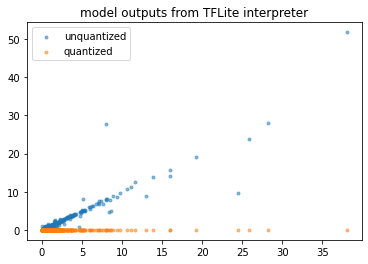

In [36]:
plt.title("model outputs from TFLite interpreter")
plt.scatter(flat_true_pts, flat_pred_pts, label="unquantized", marker=".", alpha=0.5)
plt.scatter(flat_true_pts, flat_pred_pts_quantized, label="quantized", marker=".", alpha=0.5)
plt.legend(loc="best")

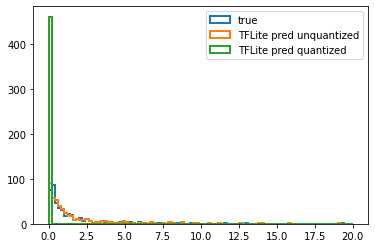

In [37]:
plt.hist(flat_true_pts, bins=np.linspace(0,20,100), histtype="step", label="true", lw=2);
plt.hist(flat_pred_pts, bins=np.linspace(0,20,100), histtype="step", label="TFLite pred unquantized", lw=2);
plt.hist(flat_pred_pts_quantized, bins=np.linspace(0,20,100), histtype="step", label="TFLite pred quantized", lw=2);
plt.legend(loc="best")

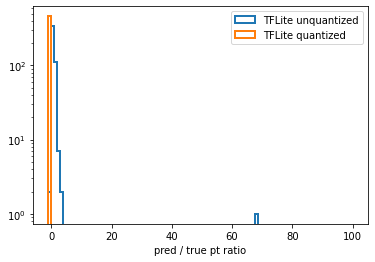

In [38]:
plt.hist(flat_pred_pts/flat_true_pts, bins=np.linspace(-1,100,101), histtype="step", lw=2, label="TFLite unquantized")
plt.hist(flat_pred_pts_quantized/flat_true_pts, bins=np.linspace(-1,100,101), histtype="step", lw=2, label="TFLite quantized")
#plt.axvline(1.0, color="black")
plt.yscale("log")
plt.xlabel("pred / true pt ratio")
plt.legend()